In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
# pd.options.display.max_columns = None
# df_pre = pd.read_csv('df_with_images.csv')
# display(df_pre)

<h5>Uncomment and run this code to resize all images to 600x600</h5>

In [7]:
##Run this code to resize all the images!!!!!!!!!!!!!!!!!!!!!!!

# import os
# import pandas as pd
# from PIL import Image

# # Load your DataFrame

# # Create the output folder if it doesn't exist
# output_folder = 'resized_images'
# os.makedirs(output_folder, exist_ok=True)

# # Loop through each row in the DataFrame
# for index, row in df_pre.iterrows():
#     # Get the original image path
#     original_image_path = row['Image Path']

#     try:
#         # Open the image using Pillow (PIL)
#         image = Image.open(original_image_path)

#         # Ensure the image is in RGB color mode
#         if image.mode != 'RGB':
#             image = image.convert('RGB')

#         # Resize the image to 600x600
#         image = image.resize((600, 600))

#         # Define the new resized image path
#         new_image_path = os.path.join(output_folder, f"{index + 1}_resized.png")

#         # Save the resized image to the output folder
#         image.save(new_image_path)
#     except Exception as e:
#         print(f"Error processing image {original_image_path}: {str(e)}")

#     # Update the DataFrame with the new image path
#     df_pre.at[index, 'Image Path'] = new_image_path

# # Save the updated DataFrame
# df_pre.to_csv('updated_dataframe.csv', index=False)

# print("Images resized and DataFrame updated.")



In [8]:
df = pd.read_csv('updated_dataframe.csv')
df.columns

Index(['ID', 'Style', 'agreeableness', 'anger', 'anticipation', 'arrogance',
       'disagreeableness', 'disgust', 'fear', 'gratitude', 'happiness',
       'humility', 'love', 'optimism', 'pessimism', 'regret', 'sadness',
       'shame', 'shyness', 'surprise', 'trust', 'neutral', 'Image URL',
       'Image Path'],
      dtype='object')

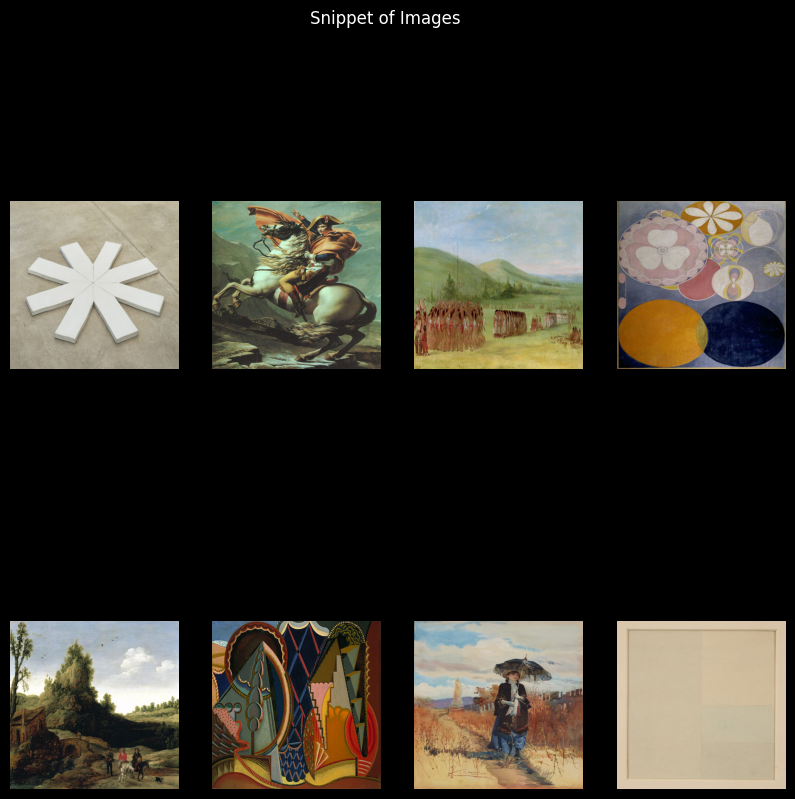

In [9]:
#preview images
# Sample 9 random rows from the DataFrame
sample_df = df.sample(9)

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
fig.suptitle('Snippet of Images')

# Loop through the subplots and display the images
for i, ax in enumerate(axes.ravel()):
    img_path = sample_df.iloc[i]['Image Path']
    img = plt.imread(img_path)  # Load the image from the file path
    ax.imshow(img)
    ax.axis('off')

plt.show()

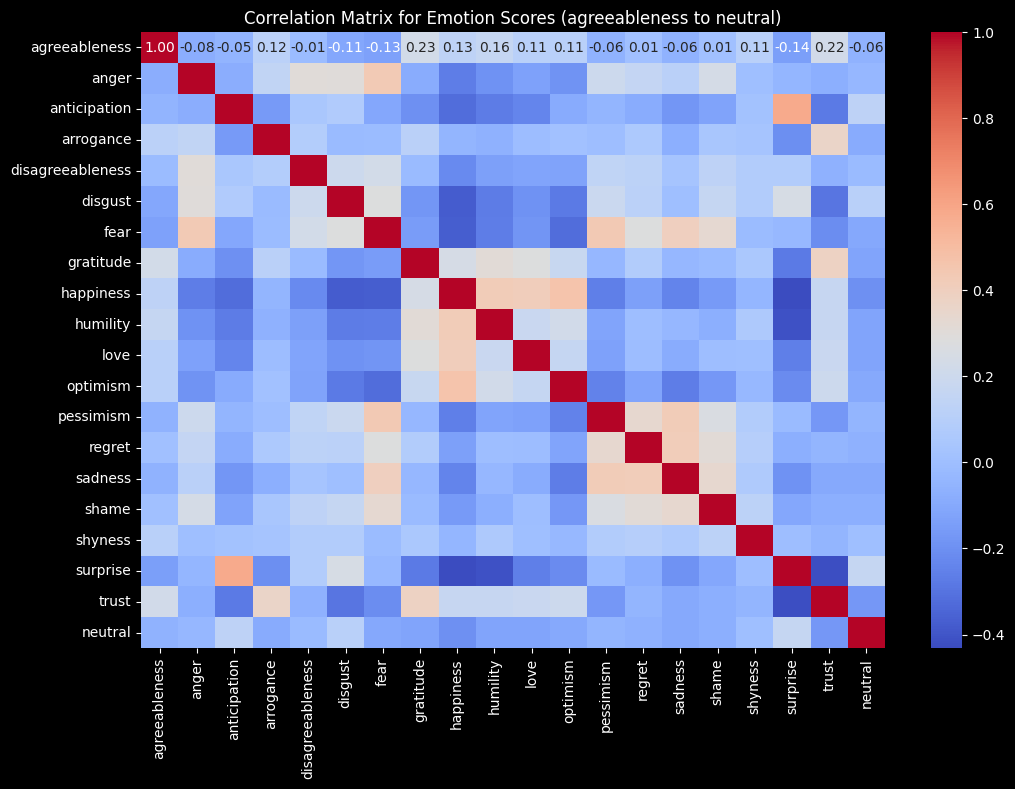

In [10]:
# Select the columns of interest
cols_of_interest = ['agreeableness', 'anger', 'anticipation', 'arrogance', 'disagreeableness', 'disgust',
                    'fear', 'gratitude', 'happiness', 'humility', 'love', 'optimism', 'pessimism', 'regret',
                    'sadness', 'shame', 'shyness', 'surprise', 'trust', 'neutral']

# Calculate the correlation matrix for the selected columns
corr_matrix = df[cols_of_interest].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Emotion Scores (agreeableness to neutral)')

# Rotate x-axis labels to 45 degrees for better readability
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)

plt.show()


In [11]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:  
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
    

No GPU available, using the CPU instead.


In [ ]:
torch.cuda.is_available()

False

<h1>Training the models</h1>
<h3>Train two different models, model 1 uses all the columns of the various emotions while model 2 where we condense all columns to just "happy","sad" or "neutral". </h3>

In [28]:
#to train model number1

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from tqdm import tqdm 

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['Image Path']
        image = Image.open(image_path).convert('RGB')

        # Apply the specified transformations
        if self.transform:
            image = self.transform(image)

        # Extract mood-related features from the dataframe
        mood_features = torch.tensor(
            [row['agreeableness'], row['anger'], row['anticipation'], row['arrogance'],
             row['disagreeableness'], row['disgust'], row['fear'], row['gratitude'],
             row['happiness'], row['humility'], row['love'], row['optimism'],
             row['pessimism'], row['regret'], row['sadness'], row['shame'],
             row['shyness'], row['surprise'], row['trust'], row['neutral']],
            dtype=torch.float32
        )

        return image, mood_features  # Return image and mood-related features

# Define a custom image transformation model
class MoodImageTransformer(nn.Module):
    def __init__(self):
        super(MoodImageTransformer, self).__init__()
        # Define your image transformation model architecture here
        self.features = models.resnet18(pretrained=True)
        # Adjust the final fully connected layer to produce 3 channels of size 600x600
        self.fc = nn.Sequential(
            nn.Linear(1000 + 20, 3 * 600 * 600)  # Add 20 for mood-related features, 3 channels for RGB, and 600x600 size
        )

    def forward(self, x, mood):
        x = self.features(x)
        # Combine the image and mood-related features
        x = torch.cat((x, mood), dim=1)
        transformed_x = self.fc(x)
        transformed_x = transformed_x.view(-1, 3, 600, 600)  # Reshape to 3x600x600
        return transformed_x

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Create a DataLoader for your dataset
custom_dataset = CustomDataset(df, transform=image_transforms)
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = MoodImageTransformer().to(device)

data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Use tqdm to create a progress bar
    for images, mood_features in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True):
        optimizer.zero_grad()
        images, mood_features = images.to(device), mood_features.to(device)  # Move data to the GPU

        print("Image shape:", images.shape)  # Debug print
        print("Mood features shape:", mood_features.shape)  # Debug print

        transformed_images = model(images, mood_features)
        loss = criterion(transformed_images, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'mood_image_transformer.pth') 

c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10:   0%|          | 0/126 [00:00<?, ?it/s]

In [6]:
#to train model number2 where we condense all columns into happy,sad or neutral
import pandas as pd
df_2 = pd.read_csv('updated_dataframe.csv')

# Combine the features into 'happy', 'neutral', and 'sad' columns
df_2['happy'] = df_2[['agreeableness', 'gratitude', 'happiness', 'love', 'optimism', 'trust']].sum(axis=1)
df_2['neutral'] = df_2['neutral']
df_2['sad'] = df_2[['anger', 'disgust', 'fear', 'sadness', 'shame', 'pessimism', 'regret', 'disagreeableness', 'shyness']].sum(axis=1)

# Drop the individual features columns
df_2 = df_2.drop(['agreeableness', 'anger', 'anticipation', 'arrogance', 'disagreeableness',
              'disgust', 'fear', 'gratitude', 'happiness', 'humility', 'love', 'optimism',
              'pessimism', 'regret', 'sadness', 'shame', 'shyness', 'surprise', 'trust'], axis=1)

df2 = df_2
df2

,ID,Style,neutral,Image URL,Image Path,happy,sad
0,58c6237dedc2c9c7dc0de1ae,Modern Art,0.0,https://uploads3.wikiart.org/00123/images/char...,resized_images\1_resized.png,1.679,0.203
1,577280dfedc2cb3880f28e76,Modern Art,0.0,https://uploads1.wikiart.org/images/keith-hari...,resized_images\2_resized.png,0.300,0.900
2,57727f2dedc2cb3880ed5fa9,Modern Art,0.0,https://uploads3.wikiart.org/images/j-zsef-rip...,resized_images\3_resized.png,1.100,0.000
3,58d1240cedc2c94f900fc610,Modern Art,0.0,https://uploads2.wikiart.org/00124/images/vady...,resized_images\4_resized.png,0.091,0.637
4,57727de7edc2cb3880e91f26,Post Renaissance Art,0.0,https://uploads6.wikiart.org/images/david-wilk...,resized_images\5_resized.png,1.001,1.771
...,...,...,...,...,...,...,...
4001,577287aeedc2cb388007fba9,Modern Art,0.0,https://uploads7.wikiart.org/images/rupprecht-...,resized_images\4002_resized.png,0.364,0.273
4002,57728001edc2cb3880efddcf,Modern Art,0.0,https://uploads4.wikiart.org/images/oscar-domi...,resized_images\4003_resized.png,0.000,1.400
4003,57728ac7edc2cb3880123cc2,Modern Art,0.0,https://uploads2.wikiart.org/images/georg-base...,resized_images\4004_resized.png,0.231,1.001
4004,57728412edc2cb3880fc9ff4,Modern Art,0.0,https://uploads0.wikiart.org/images/marie-laur...,resized_images\4005_resized.png,1.083,0.416


In [ ]:
#training model number 2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['Image Path']
        image = Image.open(image_path).convert('RGB')

        # Apply the specified transformations
        if self.transform:
            image = self.transform(image)

        # Extract mood-related features from the dataframe
        mood = torch.tensor([row['happy'], row['sad'], row['neutral']], dtype=torch.float32)

        return image, mood  # Return image and mood-related features

# Define a custom image transformation model
class MoodImageTransformer(nn.Module):
    def __init__(self):
        super(MoodImageTransformer, self).__init__()
        # Define your image transformation model architecture here
        self.features = models.resnet18(pretrained=True)
        # Adjust the final fully connected layer to produce 3 channels of size 600x600
        self.fc = nn.Sequential(
            nn.Linear(1000, 3 * 600 * 600)  # 3 channels for RGB and 600x600 size
        )

    def forward(self, x):
        x = self.features(x)
        transformed_x = self.fc(x)
        transformed_x = transformed_x.view(-1, 3, 600, 600)  # Reshape to 3x600x600
        return transformed_x

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Create a DataLoader for dataset
custom_dataset = CustomDataset(df2, transform=image_transforms)  # Use df2 instead of df
data_loader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

# Instantiate the model and move it to the specified device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MoodImageTransformer().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, moods in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True):
        optimizer.zero_grad()
        images, moods = images.to(device), moods.to(device)  # Move data to the GPU
        transformed_images = model(images)
        loss = criterion(transformed_images, images)
        loss.backward()
        optimizer.step()
        

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'mood_image_transformer2.pth')


c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 251/251 [49:48<00:00, 11.90s/it]


Epoch [1/10] Loss: 0.05645294487476349


Epoch 2/10: 100%|██████████| 251/251 [47:50<00:00, 11.44s/it]


Epoch [2/10] Loss: 0.07782291620969772


Epoch 3/10: 100%|██████████| 251/251 [48:25<00:00, 11.58s/it]


Epoch [3/10] Loss: 0.0387573279440403


Epoch 4/10: 100%|██████████| 251/251 [48:23<00:00, 11.57s/it]


Epoch [4/10] Loss: 0.05087423324584961


Epoch 5/10: 100%|██████████| 251/251 [48:27<00:00, 11.58s/it]


Epoch [5/10] Loss: 0.04748208820819855


Epoch 6/10: 100%|██████████| 251/251 [48:06<00:00, 11.50s/it]


Epoch [6/10] Loss: 0.04675320163369179


Epoch 7/10: 100%|██████████| 251/251 [48:06<00:00, 11.50s/it]


Epoch [7/10] Loss: 0.04983507841825485


Epoch 8/10: 100%|██████████| 251/251 [48:39<00:00, 11.63s/it]


Epoch [8/10] Loss: 0.02810288593173027


Epoch 9/10: 100%|██████████| 251/251 [48:16<00:00, 11.54s/it]


Epoch [9/10] Loss: 0.030498268082737923


Epoch 10/10: 100%|██████████| 251/251 [49:03<00:00, 11.73s/it]


Epoch [10/10] Loss: 0.030850611627101898


<h3>Uncomment this to clear cuda cache</h3>

In [ ]:
# #to clear cude cache

# import gc
# del MoodImageTransformer
# del image_transforms
# del images
# del moods
# del criterion
# torch.cuda.empty_cache()
# gc.collect()

<h1>Testing the output of models</h1>

<h3>Model 1</h3>

In [12]:
#to test model number 1's output

import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Load the trained model
model = MoodImageTransformer()
model.load_state_dict(torch.load('mood_image_transformer.pth'))
model.eval()

# Load the input image
image_path = "dog.jpg"
image = Image.open(image_path)
image = transforms.Compose([transforms.Resize((600, 600)), transforms.ToTensor()])(image)

# Prepare the mood information (as mood-related features)
# You need to define your mood-related features according to your use case
# For example, if you want to transform the image to a "happy" mood:
mood_features = torch.tensor([0.2, 0.1, 0.3, 0.0, 0.0, 0.0, 0.0, 0.1, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=torch.float32)

# Forward pass through the model to transform the image
transformed_image = model(image.unsqueeze(0), mood_features.unsqueeze(0))

# Convert the transformed image tensor to a PIL image
transformed_image = transforms.ToPILImage()(transformed_image[0].cpu().detach())

# Save or display the transformed image
transformed_image.save("output_image.jpg")  # Save the edited image
transformed_image.show()  # Display the edited image


NameError: name 'MoodImageTransformer' is not defined

<h3>Model 2</h3>

In [13]:

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset  # Add this import
import torchvision.transforms as transforms

# Define a custom dataset
class CustomInferenceDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        # Apply the specified transformations
        if self.transform:
            image = self.transform(image)

        return image

# Define a custom inference model
class MoodImageTransformer(nn.Module):
    def __init__(self):
        super(MoodImageTransformer, self).__init__()
        # Define your image transformation model architecture here
        self.features = models.resnet18(pretrained=True)
        # Adjust the final fully connected layer to produce 3 channels of size 600x600
        self.fc = nn.Sequential(
            nn.Linear(1000, 3 * 600 * 600)  # 3 channels for RGB and 600x600 size
        )

    def forward(self, x):
        x = self.features(x)
        transformed_x = self.fc(x)
        transformed_x = transformed_x.view(-1, 3, 600, 600)  # Reshape to 3x600x600
        return transformed_x

# Define inference image transformations
inference_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Create a list of image file paths that you want to transform
image_paths = ["house.jpg"]

# Create a DataLoader for your inference dataset
inference_dataset = CustomInferenceDataset(image_paths, transform=inference_transforms)
inference_loader = DataLoader(inference_dataset, batch_size=1)  # Batch size of 1 for inference

# Instantiate the inference model
inference_model = MoodImageTransformer()

# Load the trained model weights
inference_model.load_state_dict(torch.load('mood_image_transformer2_v2.pth'))
inference_model.eval()

# Define the mood for transformation
# Example: 'happy' mood where happy = 0.8 and other emotions add up to 0.2
mood = torch.tensor([0.9, 0.1, 0.0], dtype=torch.float32) 

# Transform images based on the specified mood
output_images = []
for image in inference_loader:
    with torch.no_grad():
        transformed_image = inference_model(image)
        transformed_image = transformed_image[0]  # Extract the transformed image from the batch
        output_images.append(transformed_image)

# Convert the transformed images to PIL format and save them
for i, output_image in enumerate(output_images):
    transformed_image = transforms.ToPILImage()(output_image)
    transformed_image.save(f"output_image_{i}.jpg")

    # Optional: Show or visualize the transformed images
    transformed_image.show()



c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Joel\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

# Load the trained model
model = MoodImageTransformer()
model.load_state_dict(torch.load('mood_image_transformer2_v2.pth'))
model.eval()

# Define a function to transform an image based on mood
def transform_image(image_path, mood):
    # Load and preprocess the input image
    image = Image.open(image_path)
    image = transforms.Compose([transforms.Resize((600, 600)), transforms.ToTensor()])(image)

    # Forward pass through the model to transform the image
    with torch.no_grad():
        transformed_image = model(image.unsqueeze(0), mood.unsqueeze(0))

    # Convert the transformed image tensor to a PIL image
    transformed_image = transforms.ToPILImage()(transformed_image[0].cpu().detach())

    return transformed_image

# Get user input for the mood (either 'happy' or 'sad')
mood_choice = input("Enter mood ('happy' or 'sad'): ")

# Define mood tensors for 'happy' and 'sad'
happy_mood = torch.tensor([0.8, 0.1, 0.1], dtype=torch.float32)
sad_mood = torch.tensor([0.1, 0.8, 0.1], dtype=torch.float32)

# Determine the mood tensor based on user input
if mood_choice == 'happy':
    mood_tensor = happy_mood
elif mood_choice == 'sad':
    mood_tensor = sad_mood
else:
    print("Invalid mood choice. Please enter 'happy' or 'sad'.")
    exit()

# Get user input for the image path
image_path = "dog.jpg"  # Replace with the path to your image

# Transform the image based on mood
transformed_image = transform_image(image_path, mood_tensor)

# Save or display the transformed image
transformed_image.save("output_image.jpg")  # Save the edited image
transformed_image.show()  # Display the edited image


In [12]:
#Trying to train another model to no avail
#Moreover, due to time restraint, we are unable to successfully train another model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Define a list of mood categories
mood_categories = ['happy', 'sad', 'neutral']

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['Image Path']
        image = Image.open(image_path).convert('RGB')

        # Apply the specified transformations
        if self.transform:
            image = self.transform(image)

        # Collect user input for mood
        mood_choice = input("Enter mood ('happy', 'sad', or 'neutral'): ")
        mood_idx = mood_categories.index(mood_choice)
        mood_vector = torch.zeros(3)
        mood_vector[mood_idx] = 1.0  # Set the corresponding mood to 1.0

        # Pass the user-specified mood
        return image, mood_vector  # Return image and mood-related features

# Define a custom image transformation model
class MoodImageTransformer(nn.Module):
    def __init__(self):
        super(MoodImageTransformer, self).__init__()
        self.features = models.resnet18(pretrained=True)
        self.fc = nn.Sequential(
            nn.Linear(1000 + 3, 3 * 600 * 600)  # 3 channels for RGB and 3 for mood, 600x600 size
        )

    def forward(self, x, mood):
        x = self.features(x)
        mood = mood.unsqueeze(0).expand(x.size(0), -1)  # Expand mood to match batch size
        x = torch.cat((x, mood), dim=1)
        transformed_x = self.fc(x)
        transformed_x = transformed_x.view(-1, 3, 600, 600)
        return transformed_x

# Define image transformations
image_transforms = transforms.Compose([
    transforms.Resize((600, 600)),
    transforms.ToTensor(),
])

# Create a DataLoader for your dataset
custom_dataset = CustomDataset(df2, transform=image_transforms)  # Use df2 instead of df
data_loader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

# Instantiate the model and move it to the specified device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MoodImageTransformer().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, moods in tqdm(data_loader, desc=f'Epoch {epoch+1}/{num_epochs}', dynamic_ncols=True):
        optimizer.zero_grad()
        images, moods = images.to(device), moods.to(device)  # Move data to the GPU

        # Call the model with the user-specified mood
        transformed_images = model(images, moods)
        loss = criterion(transformed_images, images)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item()}')

# Save the trained model
torch.save(model.state_dict(), 'mood_image_transformer2.pth')


Epoch 1/10:   0%|          | 0/251 [00:00<?, ?it/s]